In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Cplex installation on Google Colab
try:
    import cplex
except:
    !pip install cplex
    import cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 9.9 MB/s eta 0:00:00


In [3]:
# Cyipopt installation on Google Colab
try:
    import cyipopt as ipopt
except:
    !apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
    !pip install cyipopt

    import cyipopt as ipopt

from cyipopt import Problem as IpoptProblem
from cyipopt import minimize_ipopt

In [4]:
# Previous Strategy Functions from A1

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    n = len(cur_prices)
    transaction_cost_rate = 0.005  # transaction cost rate 0.5%

    # calculate the portfolio value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init

    # buy at least 1 share for target x
    x_target = np.maximum(1, np.floor((portfolio_value / n) / cur_prices))

    # change of shares holding
    delta_x = x_target - x_init

    # buy and sell value
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # transaction cost
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate

    # cash account
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sure cash account > 0
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    # final holding
    x_optimal = x_init + delta_x

    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):

    n = len(cur_prices)  # number of shares
    transaction_cost_rate = 0.005

    # initialize CPLEX
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.QP)
    problem.set_log_stream(None)  # turn off others
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    # target variable: weights
    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function: minimize w^T Q w
    quad_expr = []
    for i in range(n):
        for j in range(n):
            if Q[i][j] != 0:
                quad_expr.append((w_names[i], w_names[j], Q[i][j]))

    for w1, w2, val in quad_expr:
        problem.objective.set_quadratic_coefficients(w1, w2, val)

    problem.objective.set_sense(problem.objective.sense.minimize)

    # weights sum to 1
    problem.linear_constraints.add(
        lin_expr=[[w_names, [1.0] * n]],
        senses=["E"],
        rhs=[1.0]
    )

    # solve
    problem.solve()
    w_optimal = np.array([problem.solution.get_values(w) for w in w_names])

    # new holding
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.maximum(1, np.floor((w_optimal * portfolio_value) / cur_prices))

    # use change of x to calculate transaction cost
    delta_x = x_target - x_init

    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # calculate transaction cost and cash account
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sure cash account > 0
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    # final holding
    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal

def strat_max_return(x_init, cash_init, mu, Q, cur_prices):

    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # annualized mu and adjusted
    mu_annualized = (1 + mu) ** 252 - 1
    mu_adjusted = mu_annualized - 0.015
    mu_adjusted = mu_adjusted / np.max(np.abs(mu_adjusted))

    # initialize cplex
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.LP)  # linear programming
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function: maximize w^T mu_adjusted
    objective_coeffs = mu_adjusted.tolist()
    problem.objective.set_linear(list(zip(w_names, objective_coeffs)))
    problem.objective.set_sense(problem.objective.sense.maximize)

    # weights sum to 1
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    problem.solve()

    w_optimal = np.array([problem.solution.get_values(w) for w in w_names])

    # w_optimal in acceptable range
    w_optimal = np.clip(w_optimal, 0, 1)

    # calculate portfolio value and target x value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.maximum(1, np.floor((w_optimal * portfolio_value) / cur_prices))

    # transaction cost
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # transaction cost and cash account
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sur no negative cash
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, r_f=0.015):
    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # Adjusted expected return
    mu_adjusted = mu - r_f
    if np.all(mu_adjusted <= 0):
        mu_adjusted = mu_adjusted - np.min(mu_adjusted)

    # Initialize CPLEX
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.QP)  # Quadratic programming
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    # weights and t
    w_names = [f"w_{i}" for i in range(n)]
    t_name = "t"

    problem.variables.add(
        names=w_names + [t_name],
        types=['C'] * (n + 1),
        lb=[0] * n + [1e-6],
        ub=[1] * n + [1e6]
    )

    # maximize (w^T mu - r_f) * t
    linear_obj = [(w_names[i], float(mu_adjusted[i])) for i in range(n)] + [(t_name, 0.0)]
    problem.objective.set_linear(linear_obj)
    problem.objective.set_sense(problem.objective.sense.maximize)

    # linear constraint sum(w) = 1
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    quad_expr = [(w_names[i], w_names[j], float(Q[i, j])) for i in range(n) for j in range(n)]

    problem.quadratic_constraints.add(
        lin_expr=cplex.SparsePair(ind=[t_name], val=[-1.0]),
        quad_expr=cplex.SparseTriple(
            ind1=[q[0] for q in quad_expr],
            ind2=[q[1] for q in quad_expr],
            val=[q[2] for q in quad_expr]
        ),
        sense="L",
        rhs=0.0,
        name="SOCP_Constraint"
    )

    # Solve the optimization
    problem.solve()

    w_optimal = np.array(problem.solution.get_values(w_names))
    t_optimal = problem.solution.get_values(t_name)

    # Calculate the portfolio value and target x value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.round((w_optimal * portfolio_value) / cur_prices)

    # Calculate the transaction cost and the cash account
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # Make sure no negative cash
    while cash_optimal < -1e-6 and np.any(delta_x > 0):
        buy_indices = np.where(delta_x > 0)[0]
        if len(buy_indices) == 0:
            break
        sorted_indices = buy_indices[np.argsort(-cur_prices[buy_indices])]

        for idx in sorted_indices:
            if cash_optimal >= 0:
                break
            if delta_x[idx] > 0:
                delta_x[idx] -= 1
                cash_optimal += cur_prices[idx] - cur_prices[idx] * transaction_cost_rate

    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


In [5]:
def strat_equal_risk_contr(x_init, cash_init, mu, Sigma, cur_prices, transaction_cost_rate=0.005):
    # initial variables
    n = len(cur_prices)
    total_value = np.dot(cur_prices, x_init) + cash_init  # total value of investment
    x0 = (cur_prices * x_init) / total_value  # initial weight

    # create class same as tutorial
    class ERCP:

        def __init__(self, Sigma):
            self.Sigma = Sigma
            self.n = len(Sigma)

        # objective equal contribution on risk
        def objective(self, x):
            Ax = self.Sigma @ x
            risk_contribution = x * Ax
            total_risk = np.dot(x, Ax)
            avg_risk = total_risk / self.n
            return np.sum((risk_contribution - avg_risk) ** 2)

        def gradient(self, x):
            Ax = self.Sigma @ x
            risk_contribution = x * Ax
            total_risk = np.dot(x, Ax)
            avg_risk = total_risk / self.n
            grad = np.zeros_like(x)

            for i in range(self.n):
                term1 = (risk_contribution[i] - avg_risk) * Ax[i]
                term2 = np.sum((risk_contribution - avg_risk) * x * self.Sigma[:, i])
                grad[i] = 2 * (term1 + term2)
            return grad

        # sum to one
        def constraints(self, x):
            return np.array([np.sum(x) - 1.0])

        def jacobian(self, x):
            return np.ones(self.n)

    # set up the problem
    problem = ERCP(Sigma)
    constraints = ({'type': 'eq', 'fun': problem.constraints, 'jac': problem.jacobian})
    bounds = [(0, 1)] * n

    # get the result using ipopt
    result = minimize_ipopt(problem.objective, x0, jac=problem.gradient, constraints=constraints, bounds=bounds)

    x_opt_cont = result.x

    # transfer to integer number of shares
    x_target = np.floor(x_opt_cont * total_value / cur_prices).astype(int)

    # calculate buy/sell index, buy/sell value, and transaction cost
    delta_x = x_target - x_init
    buy_indices = delta_x > 0
    sell_indices = delta_x < 0
    buy_value = np.sum(cur_prices[buy_indices] * delta_x[buy_indices])
    sell_value = np.sum(cur_prices[sell_indices] * np.abs(delta_x[sell_indices]))
    cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - cost

    # make sure no negative cash amount
    while cash_optimal < 0 and np.any(delta_x > 0):
        sorted_buy_indices = np.argsort(-cur_prices[buy_indices])

        for idx in sorted_buy_indices:
            if cash_optimal >= 0:
                break
            if delta_x[idx] > 0:
                delta_x[idx] -= 1
                cash_optimal += cur_prices[idx] - cur_prices[idx] * transaction_cost_rate

    # get the x optimal
    x_optimal = x_init + delta_x

    return x_optimal.astype(int), cash_optimal



def strat_lever_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, r_f=0.015):

    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # calculate the adjusted mu
    mu_adjusted = mu - r_f
    if np.all(mu_adjusted <= 0):
        mu_adjusted = mu_adjusted - np.min(mu_adjusted)

    # set up the problem, no extra result coming out
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.QP)
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    w_names = [f"w_{i}" for i in range(n)]
    t_name = "t"

    # set up variables
    problem.variables.add(
        names=w_names + [t_name],
        types=['C'] * (n + 1),
        lb=[0] * n + [1e-6],
        ub=[1] * n + [1e6]
    )

    linear_obj = [(w_names[i], float(mu_adjusted[i])) for i in range(n)] + [(t_name, 0.0)]
    problem.objective.set_linear(linear_obj)
    problem.objective.set_sense(problem.objective.sense.maximize)

    # set up constraints
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    quad_expr = [(w_names[i], w_names[j], float(Q[i, j])) for i in range(n) for j in range(n)]

    problem.quadratic_constraints.add(
        lin_expr=cplex.SparsePair(ind=[t_name], val=[-1.0]),  # -t
        quad_expr=cplex.SparseTriple(
            ind1=[q[0] for q in quad_expr],
            ind2=[q[1] for q in quad_expr],
            val=[q[2] for q in quad_expr]
        ),
        sense="L",
        rhs=0.0,
        name="SOCP_Constraint"
    )

    # solve problem
    problem.solve()
    w_optimal = np.array(problem.solution.get_values(w_names))
    t_optimal = problem.solution.get_values(t_name)

    portfolio_value = np.sum(x_init * cur_prices) + cash_init

    # adding leveraged value to strategy
    leveraged_value = 2 * portfolio_value
    borrowed_amount = max(leveraged_value - portfolio_value, 0)
    interest_cost = borrowed_amount * r_f

    x_target = np.round((w_optimal * leveraged_value) / cur_prices)

    # calculating cost
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate

    cash_optimal = cash_init + sell_value - buy_value - transaction_cost - interest_cost

    # make sure non negative cash
    while cash_optimal < -1e-6 and np.any(delta_x > 0):
        buy_indices = np.where(delta_x > 0)[0]
        if len(buy_indices) == 0:
            break
        sorted_indices = buy_indices[np.argsort(-cur_prices[buy_indices])]

        for idx in sorted_indices:
            if cash_optimal >= 0:
                break
            if delta_x[idx] > 0:
                delta_x[idx] -= 1
                cash_optimal += cur_prices[idx] - cur_prices[idx] * transaction_cost_rate

    x_optimal = x_init + delta_x

    return x_optimal, cash_optimal, borrowed_amount



def strat_robust_optim(x_init, cash_init, mu, Sigma, cur_prices, transaction_cost_rate=0.005):

    n = len(cur_prices)
    total_value = np.dot(cur_prices, x_init) + cash_init

    # set up target return
    w0 = np.ones(n) / n
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, Sigma @ w0)
    target_return = ret_init * 1.05

    # set up variance tolerated
    vol = np.sqrt(np.diag(Sigma))
    small = 1e-8
    vol_safe = np.where(vol < small, small, vol)
    sharpe_indiv = (mu - 0.02) / vol_safe
    avg_sharpe = np.mean(sharpe_indiv)
    eps_est_error = abs(avg_sharpe / 2)

    prob = cplex.Cplex()
    prob.set_problem_type(cplex.Cplex.problem_type.QP)
    prob.set_log_stream(None)
    prob.set_error_stream(None)
    prob.set_warning_stream(None)
    prob.set_results_stream(None)

    # similiar to assignment 1
    w_names = [f"w_{i}" for i in range(n)]
    prob.variables.add(names=w_names, lb=[0.0] * n, ub=[1.0] * n)

    quad_expr = [(w_names[i], w_names[j], float(Sigma[i, j])) for i in range(n) for j in range(n)]
    for w1, w2, val in quad_expr:
        prob.objective.set_quadratic_coefficients(w1, w2, val)

    prob.objective.set_sense(prob.objective.sense.minimize)

    # adding constraints
    prob.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    prob.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=mu.tolist())],
        senses=["G"],
        rhs=[target_return]
    )

    # set up matrix
    diagQ = np.diag(Sigma)
    Qcon = cplex.SparseTriple(ind1=w_names, ind2=list(range(n)), val=diagQ.tolist())
    prob.quadratic_constraints.add(rhs=eps_est_error, quad_expr=Qcon, name="RobustConstraint")

    prob.solve()
    status = prob.solution.get_status()


    w_optimal = np.array(prob.solution.get_values())

    x_target = np.floor(w_optimal * total_value / cur_prices)

    delta_x = x_target - x_init
    buy_value = np.sum(cur_prices[delta_x > 0] * delta_x[delta_x > 0])
    sell_value = np.sum(cur_prices[delta_x < 0] * np.abs(delta_x[delta_x < 0]))
    cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate

    cash_optimal = cash_init + sell_value - buy_value - cost

    while cash_optimal < 0 and np.any(delta_x > 0):
        buy_indices = np.where(delta_x > 0)[0]
        if len(buy_indices) == 0:
            break
        sorted_indices = buy_indices[np.argsort(-cur_prices[buy_indices])]

        for idx in sorted_indices:
            if cash_optimal >= 0:
                break
            if delta_x[idx] > 0:
                delta_x[idx] -= 1
                cash_optimal += cur_prices[idx] - cur_prices[idx] * transaction_cost_rate

    x_optimal = x_init + delta_x

    return x_optimal.astype(int), cash_optimal



def strat_tracking_index(x_init, cash_init, mu, Sigma, cur_prices, wb, transaction_cost_rate=0.005, max_stocks=10):

    # track the S&P30 and minimize the difference
    n = len(cur_prices)
    total_value = np.dot(cur_prices, x_init) + cash_init

    prob = cplex.Cplex()
    prob.set_problem_type(cplex.Cplex.problem_type.QP)
    prob.set_log_stream(None)
    prob.set_error_stream(None)
    prob.set_warning_stream(None)
    prob.set_results_stream(None)

    w_names = [f"w_{i}" for i in range(n)]
    z_names = [f"z_{i}" for i in range(n)]

    prob.variables.add(names=w_names, lb=[0.0] * n, ub=[1.0] * n)

    prob.variables.add(names=z_names, types=['B'] * n)

    quad_expr = [(w_names[i], w_names[j], float(Sigma[i, j])) for i in range(n) for j in range(n)]
    for w1, w2, val in quad_expr:
        prob.objective.set_quadratic_coefficients(w1, w2, val)

    prob.objective.set_sense(prob.objective.sense.minimize)

    prob.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    prob.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=z_names, val=[1.0] * n)],
        senses=["L"],
        rhs=[max_stocks]
    )

    for i in range(n):
        prob.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind=[w_names[i], z_names[i]], val=[1.0, -1.0])],
            senses=["L"],
            rhs=[0.0]
        )

    prob.solve()
    status = prob.solution.get_status()

    w_optimal = np.array(prob.solution.get_values(w_names))
    w_optimal = np.nan_to_num(w_optimal)

    x_target = np.floor(w_optimal * total_value / cur_prices)

    return x_target.astype(int), cash_init


In [6]:
# Input file
input_file_prices = 'adjclose_2020_2021.csv'


In [7]:
df = pd.read_csv(input_file_prices)

# similiar function as assignment 1
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

# similiar procedure as using strategy functions as assignment 1
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:, 0] == 2019)[0]) if '2021' in input_file_prices else len(np.where(dates_array[:, 0] == 2020)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0, :] / data_prices[day_ind_start0:day_ind_end0-1, :] - 1
cur_returns0[np.isnan(cur_returns0)] = 0
mu = np.mean(cur_returns0, axis=0)
Q = np.cov(cur_returns0.T)

data_prices = data_prices[day_ind_end0:, :]
dates_array = dates_array[day_ind_end0:, :]
dates = dates[day_ind_end0:]

init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])
init_value = np.dot(data_prices[0, :], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# more functions
strategy_functions = [
    'strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance',
    'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr',
    'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index'
]
# more strategies
strategy_names = [
    'Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio',
    'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio',
    'Equal Risk Contribution Portfolio', 'Leveraged Maximum Sharpe Ratio Portfolio',
    'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio'
]

fh_array = [
    strat_buy_and_hold, strat_equally_weighted, strat_min_variance,
    strat_max_return, strat_max_Sharpe, strat_equal_risk_contr,
    strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index
]

N_strat = len(strategy_functions)
N_days = len(dates)
N_periods = 12

initial_prices = data_prices[0, :]
market_caps = np.random.rand(len(initial_prices)) * initial_prices
wb = market_caps / np.sum(market_caps)

portf_value = [np.zeros(N_days) for _ in range(N_strat)]
x = np.zeros((N_strat, N_periods), dtype=object)
cash = np.zeros((N_strat, N_periods))

for period in range(1, N_periods + 1):
    cur_year = 2020 + (period - 1) // 6
    cur_month = 2 * ((period - 1) % 6) + 1

    valid_days_start = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month))[0]
    valid_days_end = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1))[0]

    if len(valid_days_start) == 0 or len(valid_days_end) == 0:
        print(f"Skipping period {period} due to missing trading days.")
        continue

    day_ind_start = valid_days_start[0]
    day_ind_end = valid_days_end[-1] if len(valid_days_end) > 0 else day_ind_start

    print('\nPeriod {0}: start date {1}, end date {2}'.format(
          period, dates[day_ind_start], dates[day_ind_end]))

    cur_prices = data_prices[day_ind_start, :]

    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions.copy()
            curr_cash = 0.0
            portf_value[strategy] = np.zeros(N_days)
        else:
            curr_positions = x[strategy, period - 2].copy()
            curr_cash = float(cash[strategy, period - 2])

        # special request for benchmark traking strategy, input number difference
        if strategy_names[strategy] == "Benchmark Tracking Portfolio":
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, wb)
        else:
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # special request for leveraged max sharpe strategy, output number difference
        if strategy_names[strategy] == "Leveraged Maximum Sharpe Ratio Portfolio":
            x_new, cash_new, borrowed_amount = result
        else:
             x_new, cash_new = result

        x_new = np.round(x_new).astype(int)
        x[strategy, period - 1] = x_new
        cash[strategy, period - 1] = float(cash_new)

        p_values = np.dot(data_prices[day_ind_start:day_ind_end + 1], x_new) + cash_new
        portf_value[strategy][day_ind_start:day_ind_end + 1] = p_values

        # get the result
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(
            strategy_names[strategy],
            portf_value[strategy][day_ind_start],
            portf_value[strategy][day_ind_end],
            cash[strategy, period - 1]
        ))

    cur_returns = data_prices[day_ind_start + 1:day_ind_end + 1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    cur_returns[np.isnan(cur_returns)] = 0
    mu = np.mean(cur_returns, axis=0)
    Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000016.96


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990729.82, value end = $ 904015.58, cash account = $7.56
  Strategy "Minimum Variance Portfolio", value begin = $ 990212.13, value end = $ 906923.01, cash account = $0.33
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990067.38, value end = $ 917046.64, cash account = $9.90
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 989966.45, value end = $ 916980.03, cash account = $12.28
  Strategy "Equal Risk Contribution Portfolio", value begin = $ 990626.96, value end = $ 901829.56, cash account = $144.05
  Strategy "Leveraged Maximum Sharpe Ratio Portfolio", value begin = $ 964840.30, value end = $ 893707.32, cash account = $25.33
  Strategy "Robust Optimization Portfolio", value begin = $ 990175.51, value end = $

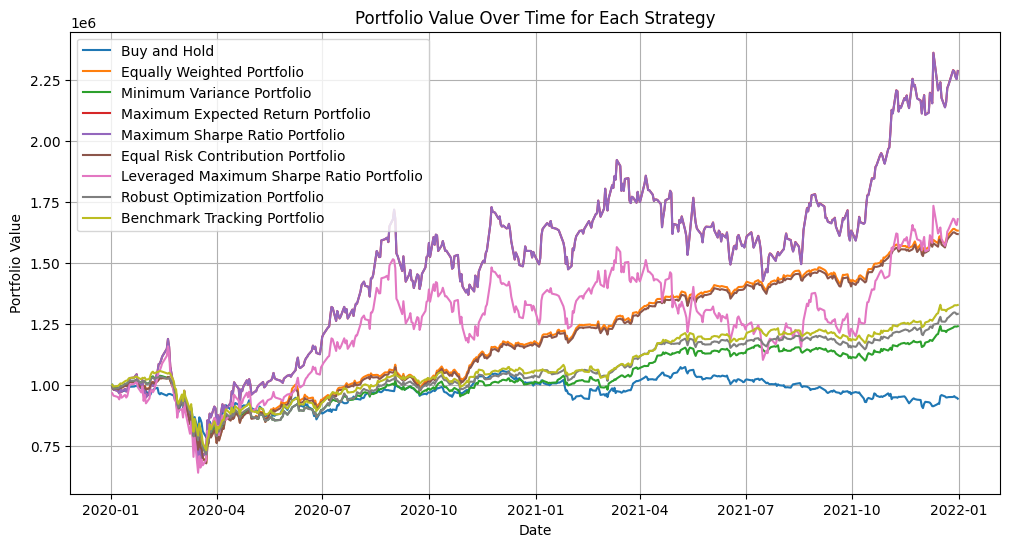

In [8]:
portf_value = np.array(portf_value)  # N_strat, N_days
dates = pd.to_datetime(dates)

# plot the lines
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy].flatten(), label=strategy_names[strategy])

# format the graph
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Each Strategy")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

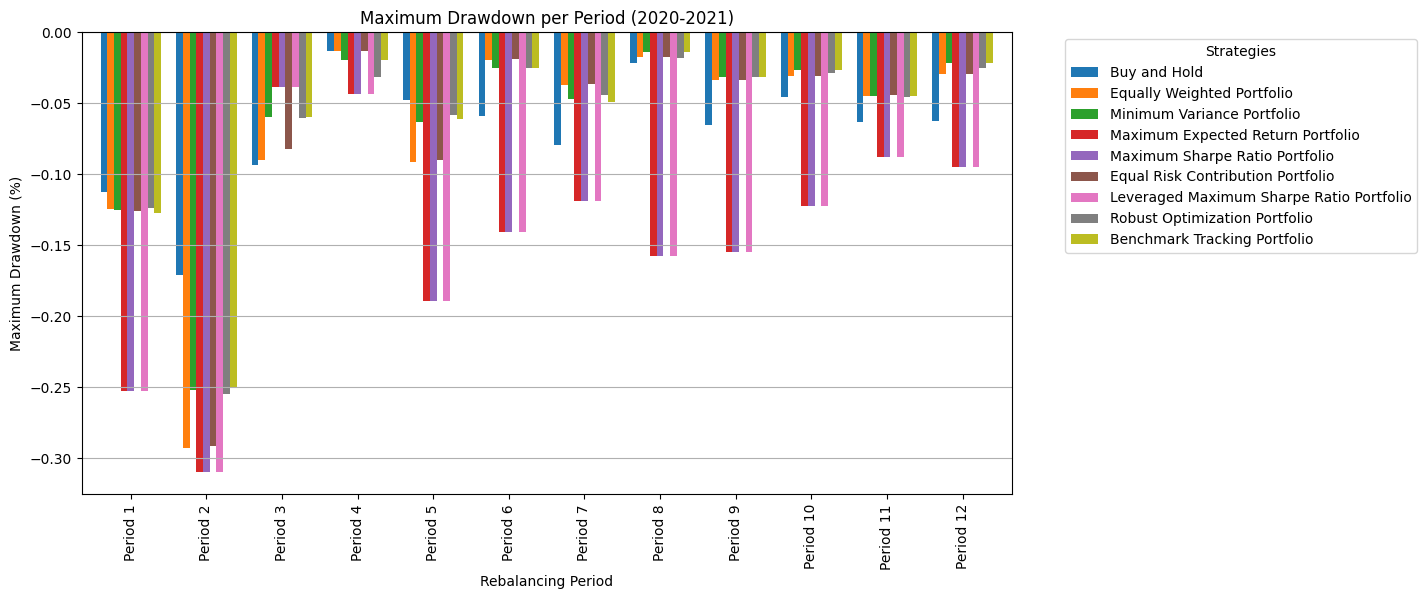

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# max drawdown function
def max_drawdown(series):
    series = pd.Series(series)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown.min()

mdd_data = {strategy: [] for strategy in strategy_names}
period_labels = []

rebalance_dates = pd.date_range(start="2020-01-02", end="2021-12-31", periods=N_periods + 1)

# iterate periods and strategies for drawing drawdown graph
for period in range(N_periods):
    start_date = rebalance_dates[period]
    end_date = rebalance_dates[period + 1]

    period_labels.append(f"Period {period + 1}")

    for strategy in range(N_strat):
        strategy_series = pd.Series(portf_value[strategy], index=dates)
        strategy_series = strategy_series.loc[start_date:end_date]

        if len(strategy_series) > 0:
            mdd_data[strategy_names[strategy]].append(max_drawdown(strategy_series))
        else:
            mdd_data[strategy_names[strategy]].append(np.nan)

df_mdd = pd.DataFrame(mdd_data, index=period_labels)

plt.figure(figsize=(12, 6))
df_mdd.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.xlabel("Rebalancing Period")
plt.ylabel("Maximum Drawdown (%)")
plt.title("Maximum Drawdown per Period (2020-2021)")
plt.legend(title="Strategies", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


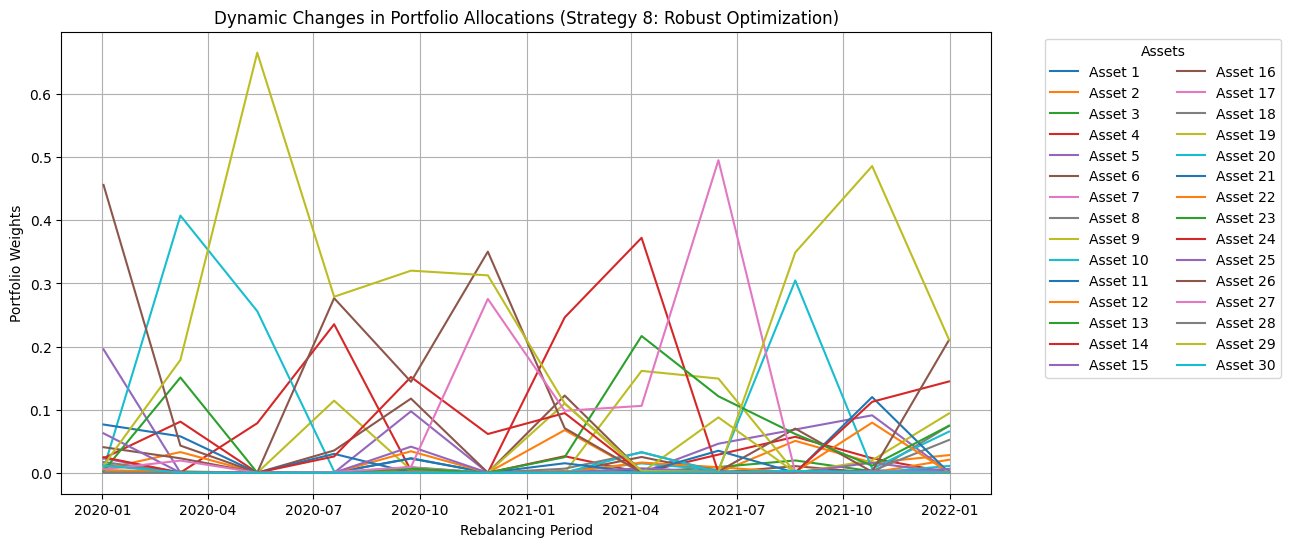

In [10]:
strategy_8_weights = np.array([x[7, period] / np.sum(x[7, period]) for period in range(N_periods)]).T

rebalance_dates = pd.date_range(start="2020-01-02", end="2021-12-31", periods=N_periods)

plt.figure(figsize=(12, 6))

N_assets = strategy_8_weights.shape[0]
for asset in range(N_assets):
    plt.plot(rebalance_dates, strategy_8_weights[asset, :], label=f"Asset {asset + 1}")

plt.xlabel("Rebalancing Period")
plt.ylabel("Portfolio Weights")
plt.title("Dynamic Changes in Portfolio Allocations (Strategy 8: Robust Optimization)")
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True)
plt.show()


#2008-2009

In [11]:
# Input file
input_file_prices = 'adjclose_2008_2009.csv'

df = pd.read_csv(input_file_prices)

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# change for different dataset
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:, 0] == 2007)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0, :] / data_prices[day_ind_start0:day_ind_end0-1, :] - 1
cur_returns0[np.isnan(cur_returns0)] = 0
mu = np.mean(cur_returns0, axis=0)
Q = np.cov(cur_returns0.T)

data_prices = data_prices[day_ind_end0:, :]
dates_array = dates_array[day_ind_end0:, :]
dates = dates[day_ind_end0:]

init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])
init_value = np.dot(data_prices[0, :], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

initial_prices = data_prices[0, :]
market_caps = initial_prices * np.random.rand(len(initial_prices))
wb = market_caps / np.sum(market_caps)

strategy_names = [
    'Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio',
    'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio',
    'Equal Risk Contribution Portfolio', 'Leveraged Maximum Sharpe Ratio Portfolio',
    'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio'
]

fh_array = [
    strat_buy_and_hold, strat_equally_weighted, strat_min_variance,
    strat_max_return, strat_max_Sharpe, strat_equal_risk_contr,
    strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index
]

N_strat = len(strategy_names)
N_days = len(dates)
N_periods = 12

portf_value = [np.zeros(N_days) for _ in range(N_strat)]
x = np.zeros((N_strat, N_periods), dtype=object)
cash = np.zeros((N_strat, N_periods))

for period in range(1, N_periods + 1):
    cur_year = 2008 + (period - 1) // 6
    cur_month = 2 * ((period - 1) % 6) + 1

    valid_days_start = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month))[0]
    valid_days_end = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1))[0]

    if len(valid_days_start) == 0 or len(valid_days_end) == 0:
        print(f"Skipping period {period} due to missing trading days.")
        continue

    day_ind_start = valid_days_start[0]
    day_ind_end = valid_days_end[-1] if len(valid_days_end) > 0 else day_ind_start

    print('\nPeriod {0}: start date {1}, end date {2}'.format(
          period, dates[day_ind_start], dates[day_ind_end]))

    cur_prices = data_prices[day_ind_start, :]

    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions.copy()
            curr_cash = 0.0
            portf_value[strategy] = np.zeros(N_days)
        else:
            curr_positions = x[strategy, period - 2].copy()
            curr_cash = float(cash[strategy, period - 2])

        if strategy_names[strategy] == "Benchmark Tracking Portfolio":
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, wb)
        else:
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        if strategy_names[strategy] == "Leveraged Maximum Sharpe Ratio Portfolio":
            x_new, cash_new, borrowed_amount = result
        else:
             x_new, cash_new = result

        x_new = np.round(x_new).astype(int)
        x[strategy, period - 1] = x_new
        cash[strategy, period - 1] = float(cash_new)

        p_values = np.dot(data_prices[day_ind_start:day_ind_end + 1], x_new) + cash_new
        portf_value[strategy][day_ind_start:day_ind_end + 1] = p_values

        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(
            strategy_names[strategy],
            portf_value[strategy][day_ind_start],
            portf_value[strategy][day_ind_end],
            cash[strategy, period - 1]
        ))

    cur_returns = data_prices[day_ind_start + 1:day_ind_end + 1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    cur_returns[np.isnan(cur_returns)] = 0
    mu = np.mean(cur_returns, axis=0)
    Q = np.cov(cur_returns.T)



Initial portfolio value = $ 431667.19


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 431667.19, value end = $ 362791.58, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 427658.14, value end = $ 380510.14, cash account = $1.58
  Strategy "Minimum Variance Portfolio", value begin = $ 427372.60, value end = $ 395519.14, cash account = $26.52
  Strategy "Maximum Expected Return Portfolio", value begin = $ 427372.69, value end = $ 350608.30, cash account = $44.60
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 427328.52, value end = $ 350494.38, cash account = $28.77
  Strategy "Equal Risk Contribution Portfolio", value begin = $ 427742.69, value end = $ 379065.88, cash account = $40.88
  Strategy "Leveraged Maximum Sharpe Ratio Portfolio", value begin = $ 416482.89, value end = $ 341599.07, cash account = $29.46
  Strategy "Robust Optimization Portfolio", value begin = $ 427337.12, value end = $ 

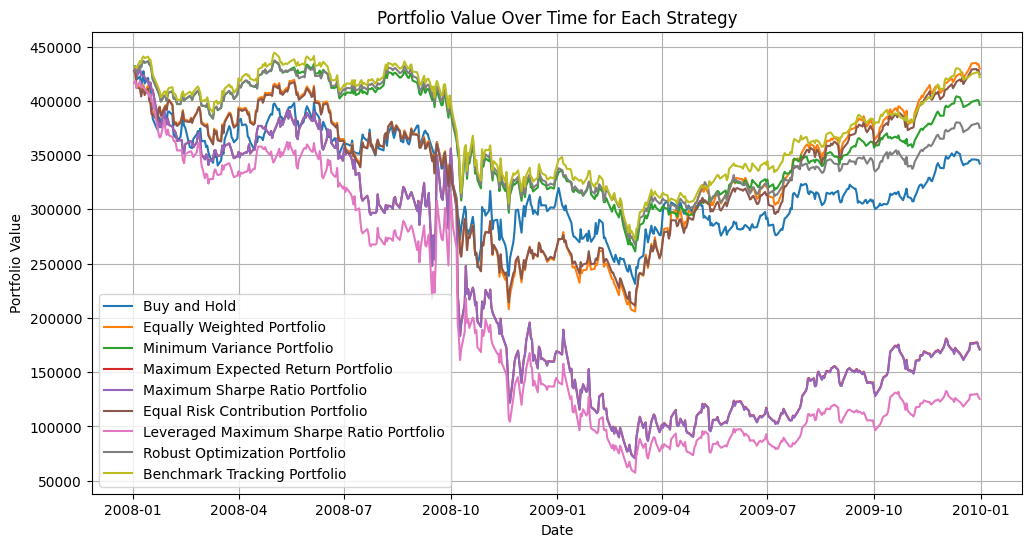

In [12]:
portf_value = np.array(portf_value)  # N_strat, N_days
dates = pd.to_datetime(dates)

# plot the lines
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy].flatten(), label=strategy_names[strategy])

# format the graph
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Each Strategy")
plt.legend()
plt.grid(True)
plt.show()


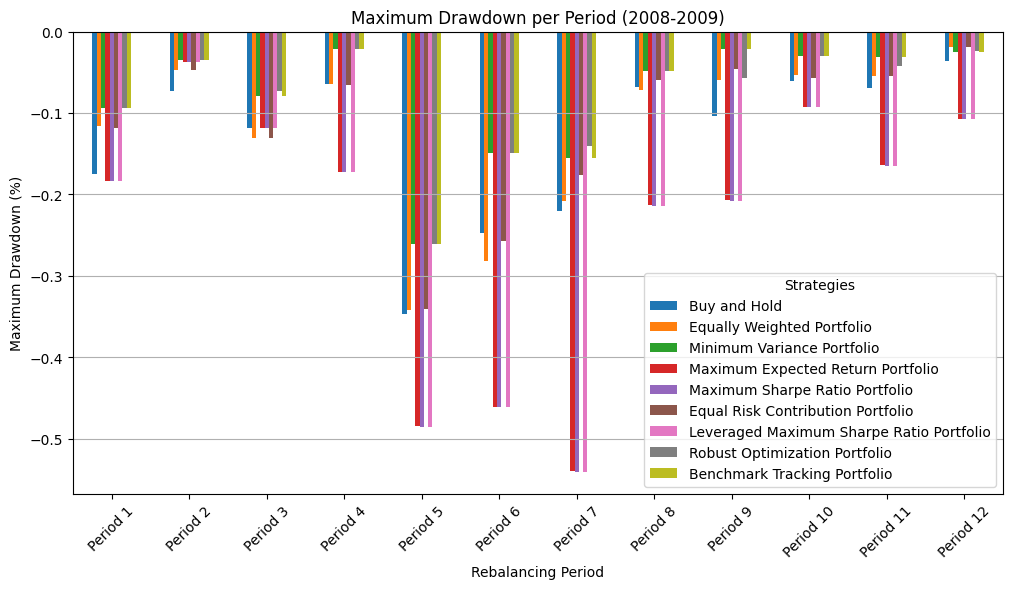

In [13]:
period_boundaries = [
    "2008-01-02",
    "2008-03-01",
    "2008-05-01",
    "2008-07-01",
    "2008-09-02",
    "2008-11-03",
    "2009-01-02",
    "2009-03-02",
    "2009-05-01",
    "2009-07-01",
    "2009-09-01",
    "2009-11-02",
    "2009-12-31"
]
periods = pd.to_datetime(period_boundaries)

if len(dates) != portf_value.shape[1]:
    dates = dates[:portf_value.shape[1]]

mdd_data = {strategy: [] for strategy in strategy_names}

for i in range(len(periods) - 1):
    period_start, period_end = periods[i], periods[i + 1]

    for strategy in strategy_names:
        strategy_idx = strategy_names.index(strategy)

        mask = (dates >= period_start) & (dates < period_end)
        filtered_values = portf_value[strategy_idx][mask]

        if len(filtered_values) == 0:
            mdd_data[strategy].append(np.nan)
        else:
            mdd_data[strategy].append(max_drawdown(filtered_values))

df_mdd = pd.DataFrame(mdd_data, index=[f"Period {i+1}" for i in range(len(periods) - 1)])

df_mdd.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Rebalancing Period")
plt.ylabel("Maximum Drawdown (%)")
plt.title("Maximum Drawdown per Period (2008-2009)")
plt.legend(title="Strategies")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

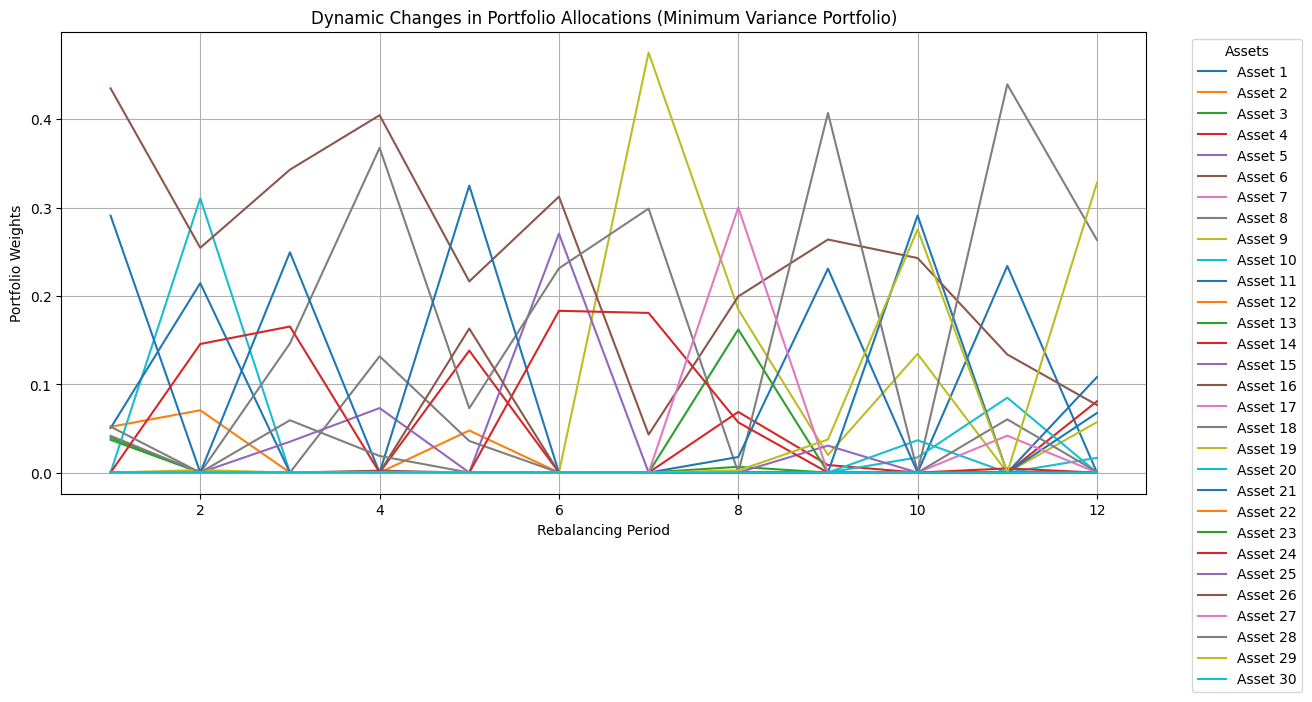

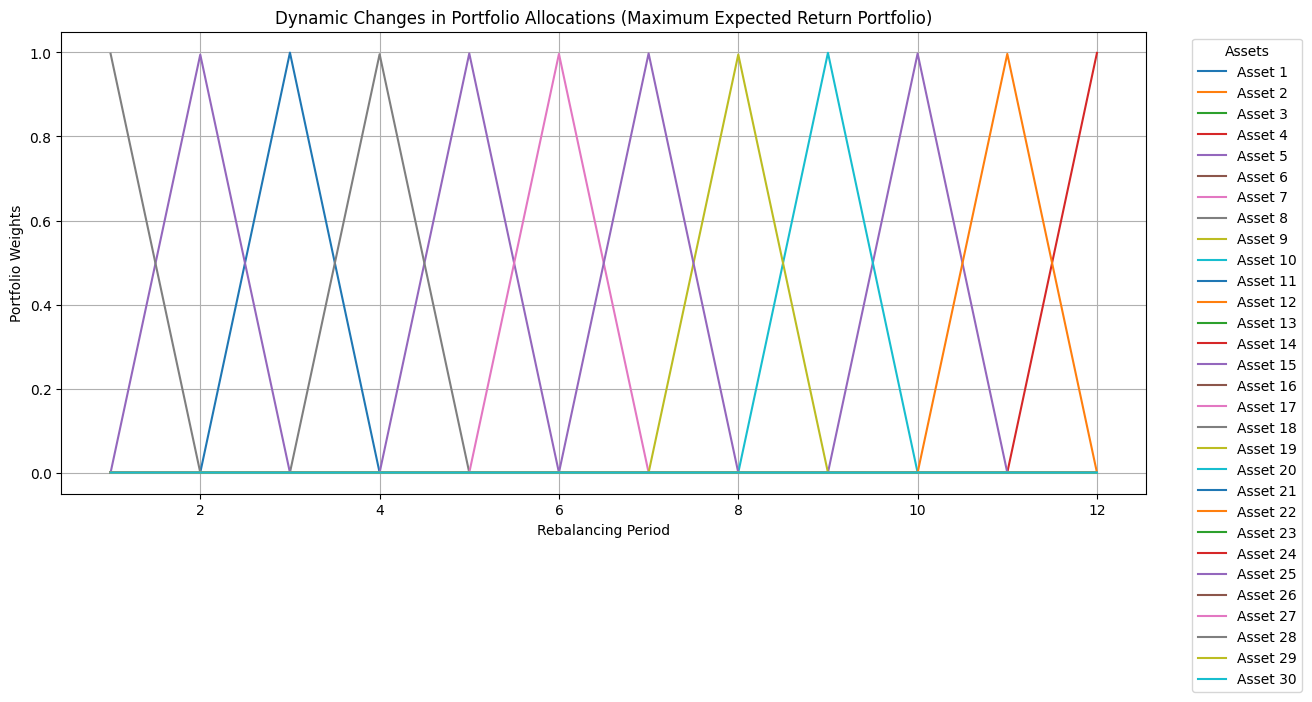

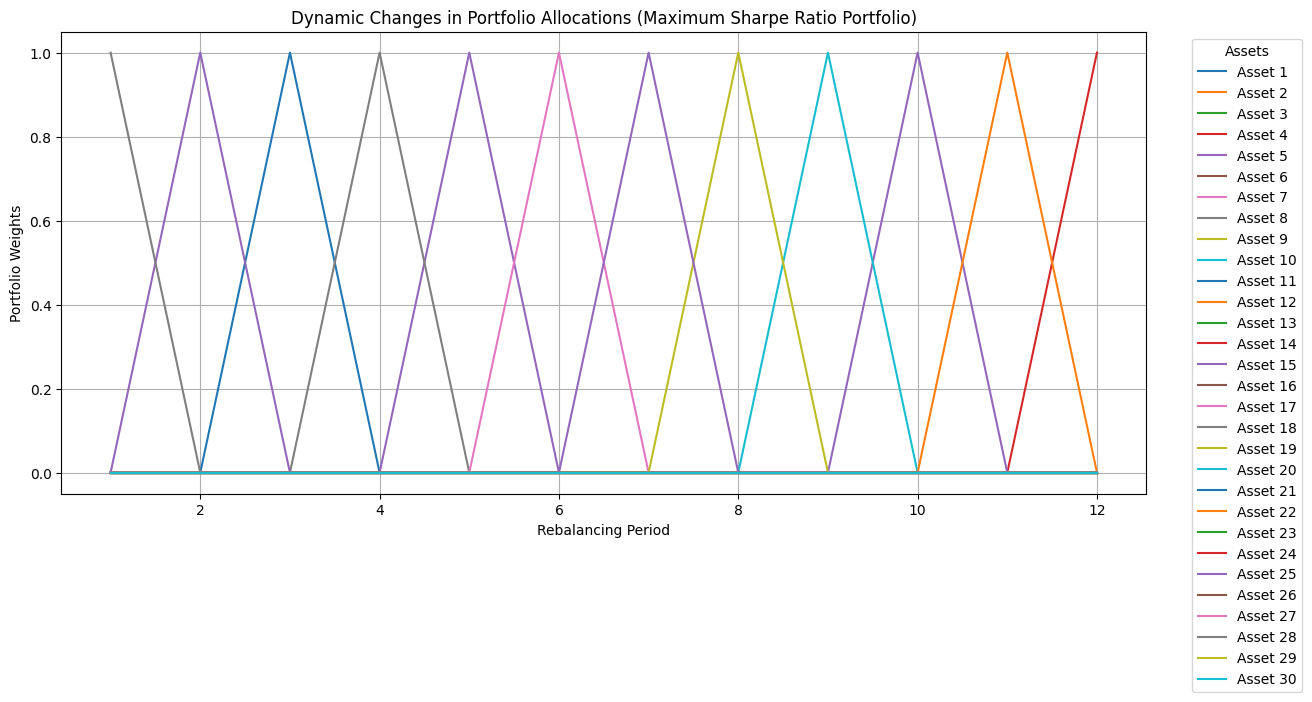

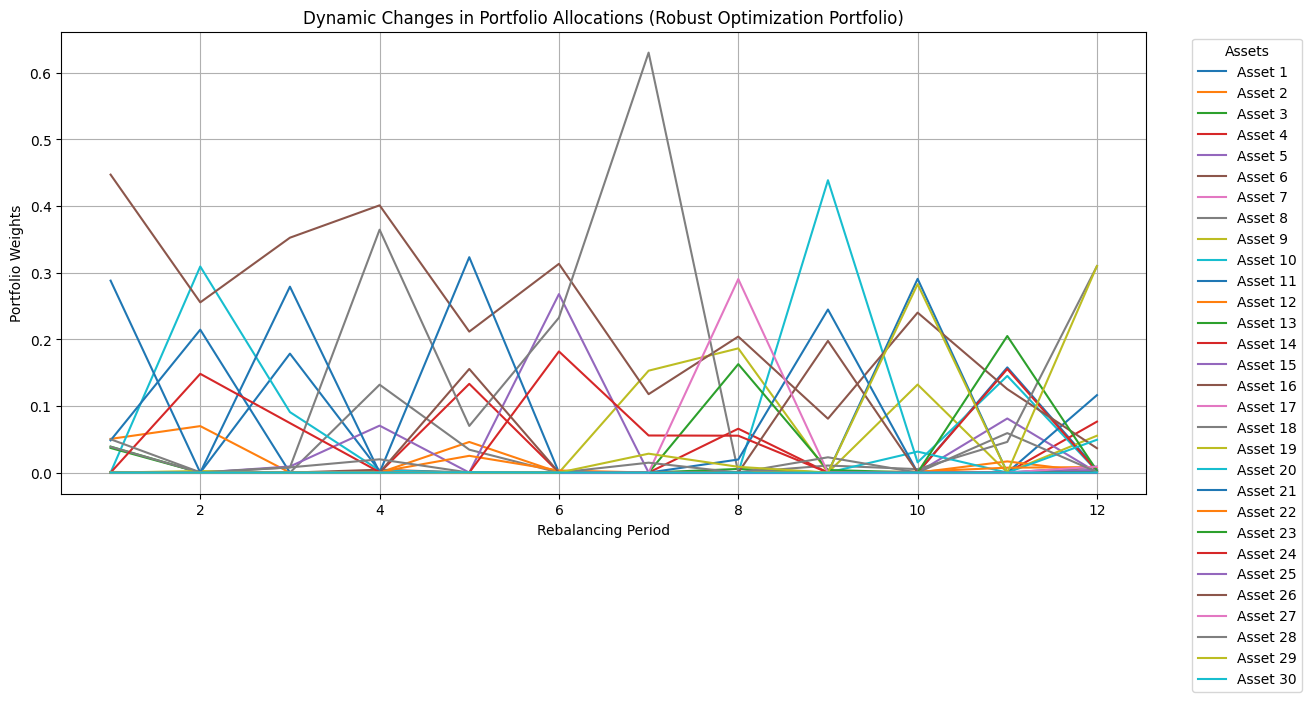

In [14]:
strategy_indices = [2, 3, 4, 7]
strategy_labels = ["Minimum Variance Portfolio", "Maximum Expected Return Portfolio",
                   "Maximum Sharpe Ratio Portfolio", "Robust Optimization Portfolio"]

for strat_idx, strat_label in zip(strategy_indices, strategy_labels):
    plt.figure(figsize=(14, 6))

    allocations = np.array([x[strat_idx, i] / np.sum(x[strat_idx, i]) for i in range(N_periods)])

    for asset_idx in range(allocations.shape[1]):
        plt.plot(range(1, N_periods+1), allocations[:, asset_idx], label=f"Asset {asset_idx+1}")

    plt.xlabel("Rebalancing Period")
    plt.ylabel("Portfolio Weights")
    plt.title(f"Dynamic Changes in Portfolio Allocations ({strat_label})")
    plt.legend(title="Assets", loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.show()


#2022

In [15]:
input_file_prices = "adjclose_2022.csv"
df = pd.read_csv(input_file_prices)

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(pd.to_datetime(df['Date']))

day_ind_start0 = 0
day_ind_end0 = len(dates)

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0, :] / data_prices[day_ind_start0:day_ind_end0-1, :] - 1
cur_returns0[np.isnan(cur_returns0)] = 0
mu = np.mean(cur_returns0, axis=0)
Q = np.cov(cur_returns0.T)


In [16]:
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])
init_value = np.dot(data_prices[0, :], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

strategy_names = [
    'Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio',
    'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio',
    'Equal Risk Contribution Portfolio', 'Leveraged Maximum Sharpe Ratio Portfolio',
    'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio'
]

fh_array = [
    strat_buy_and_hold, strat_equally_weighted, strat_min_variance,
    strat_max_return, strat_max_Sharpe, strat_equal_risk_contr,
    strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index
]

N_strat = len(strategy_names)
N_days = len(dates)
N_periods = 6

initial_prices = data_prices[0, :]
market_caps = np.random.rand(len(initial_prices)) * initial_prices
wb = market_caps / np.sum(market_caps)

portf_value = [np.zeros(N_days) for _ in range(N_strat)]
x = np.zeros((N_strat, N_periods), dtype=object)
cash = np.zeros((N_strat, N_periods))

for period in range(1, N_periods + 1):
    cur_month = 2 * (period - 1) + 1

    valid_days_start = np.where((dates_array[:, 0] == 2022) & (dates_array[:, 1] == cur_month))[0]
    valid_days_end = np.where((dates_array[:, 0] == 2022) & (dates_array[:, 1] == cur_month + 1))[0]

    if len(valid_days_start) == 0 or len(valid_days_end) == 0:
        print(f"Skipping period {period} due to missing trading days.")
        continue

    day_ind_start = valid_days_start[0]
    day_ind_end = valid_days_end[-1] if len(valid_days_end) > 0 else day_ind_start

    print('\nPeriod {0}: start date {1}, end date {2}'.format(
          period, dates[day_ind_start], dates[day_ind_end]))

    cur_prices = data_prices[day_ind_start, :]

    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions.copy()
            curr_cash = 0.0
            portf_value[strategy] = np.zeros(N_days)
        else:
            curr_positions = x[strategy, period - 2].copy()
            curr_cash = float(cash[strategy, period - 2])

        if strategy_names[strategy] == "Benchmark Tracking Portfolio":
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, wb)
        else:
            result = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        if strategy_names[strategy] == "Leveraged Maximum Sharpe Ratio Portfolio":
            x_new, cash_new, borrowed_amount = result
        else:
            x_new, cash_new = result

        x_new = np.round(x_new).astype(int)
        x[strategy, period - 1] = x_new
        cash[strategy, period - 1] = float(cash_new)

        p_values = np.dot(data_prices[day_ind_start:day_ind_end + 1], x_new) + cash_new
        portf_value[strategy][day_ind_start:day_ind_end + 1] = p_values

        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(
            strategy_names[strategy],
            portf_value[strategy][day_ind_start],
            portf_value[strategy][day_ind_end],
            cash[strategy, period - 1]
        ))

    cur_returns = data_prices[day_ind_start + 1:day_ind_end + 1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    cur_returns[np.isnan(cur_returns)] = 0
    mu = np.mean(cur_returns, axis=0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 964589.63


Period 1: start date 2022-01-03T00:00:00.000000000, end date 2022-02-28T00:00:00.000000000
  Strategy "Buy and Hold", value begin = $ 950205.84, value end = $ 992093.09, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 941380.98, value end = $ 878992.49, cash account = $12.18
  Strategy "Minimum Variance Portfolio", value begin = $ 942409.61, value end = $ 945942.46, cash account = $68.88
  Strategy "Maximum Expected Return Portfolio", value begin = $ 940751.98, value end = $ 1172733.72, cash account = $29.59
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 940655.77, value end = $ 1173799.34, cash account = $50.21
  Strategy "Equal Risk Contribution Portfolio", value begin = $ 941323.98, value end = $ 881035.17, cash account = $67.47
  Strategy "Leveraged Maximum Sharpe Ratio Portfolio", value begin = $ 916781.47, value end = $ 1144018.19, cash account = $6.78
  Strategy "Robust Optimization Portfolio", 

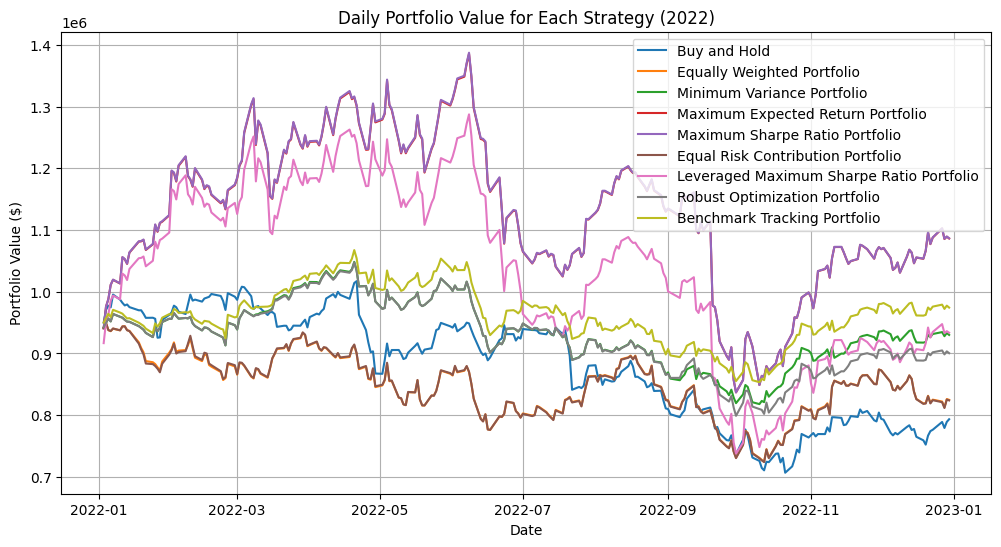

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

portf_value = np.array(portf_value)
dates = pd.to_datetime(dates)

# 2022-01-03 - 2022-12-31
mask = (dates >= '2022-01-03') & (dates <= '2022-12-31')
filtered_dates = dates[mask]
filtered_portf_value = portf_value[:, mask]

plt.figure(figsize=(12, 6))
for i in range(N_strat):
    plt.plot(filtered_dates, filtered_portf_value[i], label=strategy_names[i])

plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Daily Portfolio Value for Each Strategy (2022)")
plt.legend()
plt.grid(True)
plt.show()


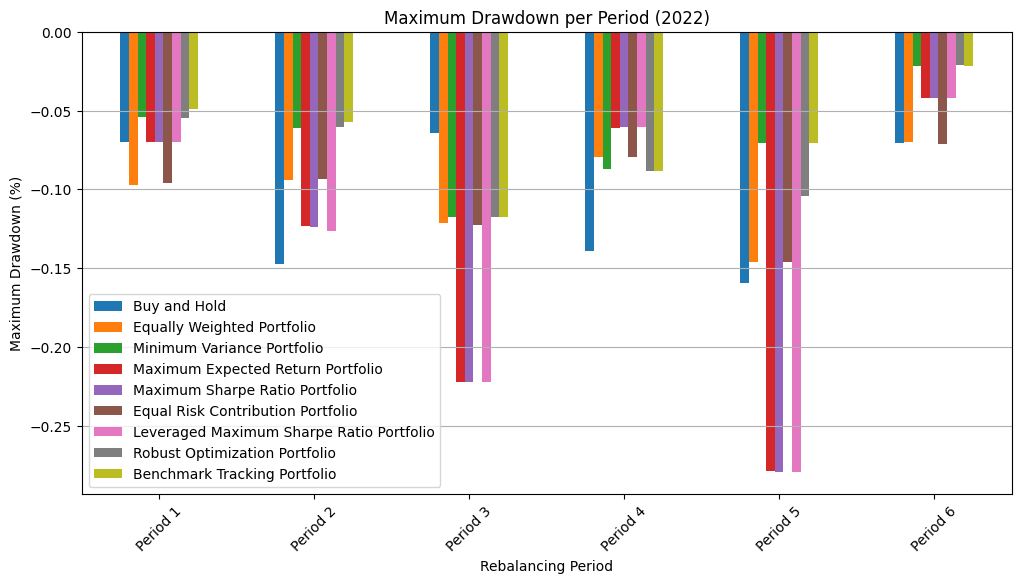

In [18]:
period_boundaries = [
    "2022-01-03",
    "2022-03-01",
    "2022-05-01",
    "2022-07-01",
    "2022-09-01",
    "2022-11-01",
    "2023-01-01"
]
periods = pd.to_datetime(period_boundaries)

mdd_data = {strategy: [] for strategy in strategy_names}

for i in range(len(periods) - 1):
    period_start, period_end = periods[i], periods[i + 1]

    for strategy in strategy_names:
        strategy_idx = strategy_names.index(strategy)
        mask = (dates >= period_start) & (dates < period_end)
        filtered_values = portf_value[strategy_idx][mask]

        if len(filtered_values) == 0:
            mdd_data[strategy].append(np.nan)
        else:
            mdd_data[strategy].append(max_drawdown(filtered_values))

df_mdd = pd.DataFrame(mdd_data, index=[f"Period {i+1}" for i in range(len(periods) - 1)])
df_mdd.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Rebalancing Period")
plt.ylabel("Maximum Drawdown (%)")
plt.title("Maximum Drawdown per Period (2022)")
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()
